In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-03 14:45:47.254744: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-03 14:45:47.285871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 14:45:47.768390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')

df_Siri_azul = pd.DataFrame(df[['Ano','Siri_azul_art','Siri_azul_ind','Siri_azul_art_ind']])

#Somando art e ind em art_ind
for i in range(len(df_Siri_azul['Ano'])):
  if pd.isnull(df_Siri_azul.iloc[i,3])==True and pd.isnull(df_Siri_azul.iloc[i,2])==False and pd.isnull(df_Siri_azul.iloc[i,1])==False:
    df_Siri_azul.iloc[i,3] = df_Siri_azul.iloc[i,2] + df_Siri_azul.iloc[i,1] 


dados = df_Siri_azul[['Ano','Siri_azul_art','Siri_azul_art_ind']].dropna().reset_index(drop=True)

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Siri_azul_art'] = dados.loc[i,'Siri_azul_art'] / dados.loc[i,'Siri_azul_art_ind']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1962,1963,1964,1965,1966,1967,1968,1974,1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()



prop = dados['Prop_Siri_azul_art'].values

dados.head()

,Ano,Siri_azul_art,Siri_azul_art_ind,Prop_Siri_azul_art
0,1981,125.0,128.0,0.976562
1,1982,185.0,192.0,0.963542
2,1983,203.0,204.0,0.995098
3,1984,162.0,164.0,0.987805
4,1985,226.0,280.0,0.807143


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [6]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=150, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Siri_azul/pesos prop Siri_azul_art/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Siri_azul/pesos prop Siri_azul_art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.9954769 ]
 [0.993941  ]
 [0.99240494]
 [0.99086905]
 [0.98933315]
 [0.9877971 ]
 [0.98626125]
 [0.97627956]
 [0.9725999 ]
 [0.9706794 ]]


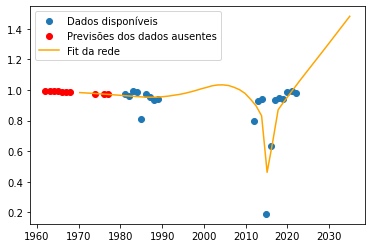

In [8]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

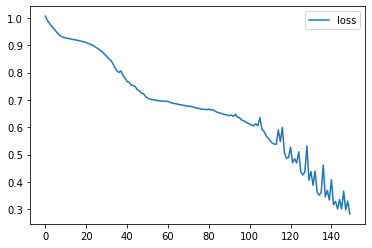

In [20]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [9]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para Siri_azul_art_ind
df_prev_Siri_azul_art_ind = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Desagregações 1950-1974/Desagregações 1950-1974.xlsx')
df_prev_Siri_azul_art_ind = df_prev_Siri_azul_art_ind[['Ano','Siri_azul_art_ind']]


df_preenchido = df[['Ano','Siri_azul_art']]
for i in range(len(prev_continua)):
    if i+1950 in anos_para_prever:
      df_preenchido.loc[i,'Siri_azul_art']=df_prev_Siri_azul_art_ind.loc[i,'Siri_azul_art_ind']*prev_continua[i]


with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Siri_azul/Previsão Siri_azul_art_1962-1977.xlsx')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     Ano  Siri_azul_art
0   1950            NaN
1   1951            NaN
2   1952            NaN
3   1953            NaN
4   1954            NaN
5   1955            NaN
6   1956            NaN
7   1957            NaN
8   1958            NaN
9   1959            NaN
10  1960            NaN
11  1961            NaN
12  1962      74.660767
13  1963     215.685196
14  1964     173.670868
15  1965     131.527420
16  1966      75.189316
17  1967     107.669884
18  1968      61.148197
19  1969            NaN
20  1970            NaN
21  1971            NaN
22  1972            NaN
23  1973            NaN
24  1974      93.801140
25  1975            NaN
26  1976     215.917191
27  1977     566.876770
28  1978      94.000000
29  1979            NaN
30  1980      59.000000
31  1981     125.000000
32  1982     185.000000
33  1983     203.000000
34  1984     162.000000
35  1985     226.000000
36  1986     234.000000
37  1987     338.000000
38  1988     355.000000
39